In [1]:
import glob
import pickle
import numpy as np
from numpy.polynomial import Polynomial
from scipy import ndimage, signal, interpolate, integrate,optimize
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014, turn_physical_off, MiyamotoNagaiPotential, plotDensities,evaluateDensities, SpiralArmsPotential
from galpy.util import bovy_conversion, save_pickles, bovy_coords, bovy_plot
import seaborn as sns
import astropy.units as u
from galpy import potential
%pylab inline
from matplotlib import cm, pyplot
import spiralarms_util
import pal5_util
from galpy.potential import DehnenSmoothWrapperPotential as DehnenWrap


ro=8.
vo=220.

#from matplotlib.ticker import FuncFormatter, NullFormatter

def galcencyl_to_lbd(R,phi,Z,degree=True):
        xyz=bovy_coords.galcencyl_to_XYZ(R,phi,Z)
        l=[]
        b=[]
        d=[]
        for ii in range(len(xyz)):
            lbd=bovy_coords.XYZ_to_lbd(xyz[ii][0],xyz[ii][1],xyz[ii][2],degree=degree)
            l.append(lbd[0])
            b.append(lbd[1])
            d.append(lbd[2])
            
        return (l,b,d)

Populating the interactive namespace from numpy and matplotlib


0.25076121308943206
/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)

/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)

/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)

/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)

/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)

/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'aspect'
  

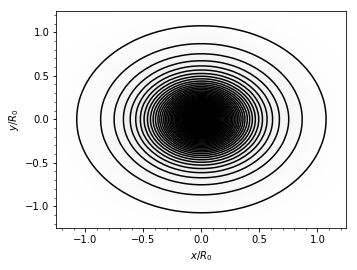

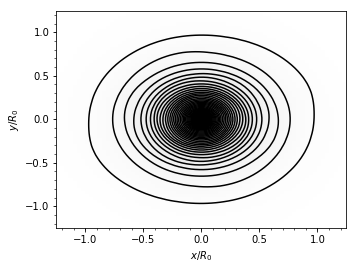

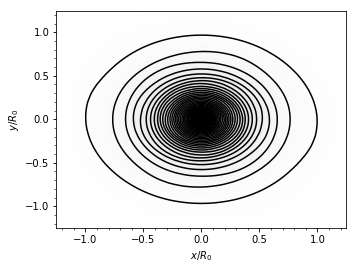

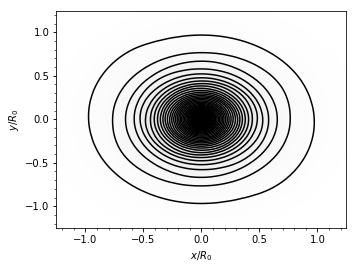

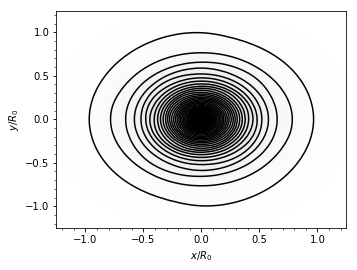

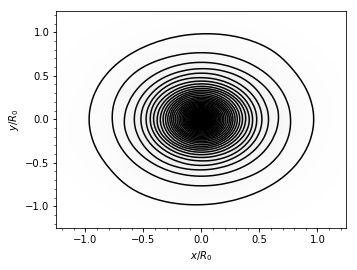

In [2]:
omega=24.5*(ro/vo)
Tspiral=2.*np.pi/np.abs(omega)

print (Tspiral*bovy_conversion.time_in_Gyr(vo,ro))

spiralpot=spiralarms_util.spiral_arms_potential(FR_frac=1.,t_on=-1.5)

#plot the spiral's density contours

plotDensities(spiralpot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,nrs=50,nzs=50,ncontours=80,xy=True,t=-2.*u.Gyr)
plotDensities(spiralpot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,nrs=70,nzs=70,ncontours=80,xy=True,t=-1.5*u.Gyr)
plotDensities(spiralpot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,nrs=70,nzs=70,ncontours=80,xy=True,t=-1.4*u.Gyr)
plotDensities(spiralpot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,nrs=70,nzs=70,ncontours=80,xy=True,t=-1.3*u.Gyr)
plotDensities(spiralpot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,nrs=70,nzs=70,ncontours=80,xy=True,t=-1.2*u.Gyr)
plotDensities(spiralpot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,nrs=70,nzs=70,ncontours=80,xy=True,t=-0.6*u.Gyr)



In [3]:
FR_frac=1.
N=4
pat_speed=24.5
fo="spiral_trailing.dat"
pitch_angle=9.9

nsample=1000

spiralarms_util.sample_streamdf_pal5_noprog_spiral(nsample,spiralpot=spiralpot,nospiralpot=MWPotential2014,fo=fo)
spiralarms_util.sample_streamdf_pal5_noprog_spiral(nsample,spiralpot=spiralpot,nospiralpot=MWPotential2014,fo=fo,trailing=False)



In [4]:
allfname_trail= 'spiral_trailing.dat'
allfname_lead= 'spiral_trailing.dat'


R_t=numpy.loadtxt(allfname_trail)[:,0]
phi_t=numpy.loadtxt(allfname_trail)[:,1]
z_t=numpy.loadtxt(allfname_trail)[:,2]
vR_=numpy.loadtxt(allfname_trail)[:,3]
vT_t=numpy.loadtxt(allfname_trail)[:,4]
vz_t=numpy.loadtxt(allfname_trail)[:,5]
t_t=numpy.loadtxt(allfname_trail)[:,6]


R_l=numpy.loadtxt(allfname_lead)[:,0]
phi_l=numpy.loadtxt(allfname_lead)[:,1]
z_l=numpy.loadtxt(allfname_lead)[:,2]
vR_l=numpy.loadtxt(allfname_lead)[:,3]
vT_l=numpy.loadtxt(allfname_lead)[:,4]
vz_l=numpy.loadtxt(allfname_lead)[:,5]
t_l=numpy.loadtxt(allfname_lead)[:,6]



In [5]:
l_t,b_t,d_t=np.array(galcencyl_to_lbd(R_t,phi_t,z_t))
l_l,b_l,d_l=np.array(galcencyl_to_lbd(R_l,phi_l,z_l))



In [6]:
radec_t=bovy_coords.lb_to_radec(l_t,b_t,degree=True) 
radec_l=bovy_coords.lb_to_radec(l_l,b_l,degree=True)


mxieta_t= pal5_util.radec_to_pal5xieta(radec_t[:,0],radec_t[:,1],degree=True)
xi_t= mxieta_t[:,0]
eta_t=mxieta_t[:,1]

mxieta_l= pal5_util.radec_to_pal5xieta(radec_l[:,0],radec_l[:,1],degree=True)
xi_l= mxieta_l[:,0]
eta_l=mxieta_l[:,1]

    

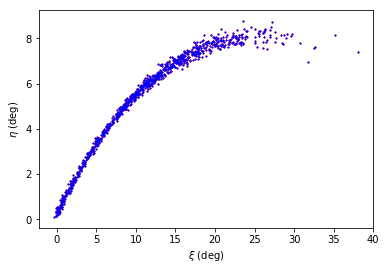

In [7]:
plt.figure()

plt.scatter(xi_t,eta_t,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(xi_l,eta_l,s=1,c='b',label='leading',alpha=1.,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel(r'$\xi$ (deg)')
plt.ylabel(r'$\eta$ (deg)')
plt.show()


## Test Jacobi integral

growing spiral


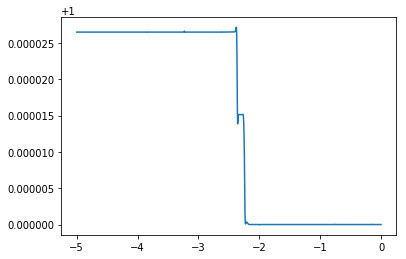

In [10]:
spiralpot=spiralarms_util.spiral_arms_potential(FR_frac=1.,t_on=-2.)

t_age=5./bovy_conversion.time_in_Gyr(vo,ro)
tt= numpy.linspace(0.,-t_age,1001)


pal5= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,solarmotion=[-11.1,24.,7.25])

pal5.integrate(tt,MWPotential2014)

p5=Orbit(pal5(tt[-1])._orb.vxvv)


ttf= numpy.linspace(-t_age,0.,1001)
p5.integrate(ttf,spiralpot)


plt.figure()
plot(ttf*bovy_conversion.time_in_Gyr(220.,8.),p5.Jacobi(ttf,OmegaP=24.5/vo*ro)/p5.Jacobi(0.,OmegaP=24.5/vo*ro))
plt.show()